# Importing ODV aggregated spreadsheet data

* Data are supposed to be aggregated using ODV and exported as aggregated ODV spreadsheet files
* Substitute the file name `small_ODV_sample.txt` with the file name of your aggregated ODV file. 
* Do not export "data error"  from ODV (column header `STANDARD_DEV`)

In [1]:
using divand
using PyPlot

In [2]:
#download("...","small_ODV_sample.txt")

Aggregated ODV files do not have a semantic header, therefore we need to extract the corresponding column by using the "local" column header name (instead of being able to use the P01 name for the ODV files conforming to 
[Specification of SeaDataNet Data Transport Formats](https://www.seadatanet.org/content/download/636/3333/file/SDN2_D85_WP8_Datafile_formats.pdf?version=2)).


By default only `good` and `probably good` values are loaded.     
This can be changed using the optional parameter `qv_flags`:

In [3]:
divand.ODVspreadsheet.GOOD_VALUE

"1"

In [2]:
?ODVspreadsheet.load

```
 profiles,lons,lats,depths,times,ids = load(T,fnames,datanames;
    qv_flags = [divand.ODVspreadsheet.GOOD_VALUE,
                divand.ODVspreadsheet.PROBABLY_GOOD_VALUE],
    nametype = :P01,
    qvlocalname = "QV:SEADATANET")
```

Load all profiles in all file from the array `fnames` corresponding to one of the parameter names `datanames`. If `nametype` is `:P01` (default), the datanames are P01 vocabulary names with the SDN prefix. If nametype is `:localname`, then they are the ODV column header without units. For example if the column header is `Water body salinity [per mille]`, then `datenames` should be `["Water body salinity"]`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively). Only values matching the quality flag `qv_flags` are retained. `qv_flags` is a vector of Strings (based on http://vocab.nerc.ac.uk/collection/L20/current/, e.g. "1" means "good value"). One can also use the constants these constants (prefixed with `divand.ODVspreadsheet.`):

`qvlocalname` is the column name to denote quality flags. It is assumed that the  quality flags follow immediatly the data column.

|                   constant | value |
| --------------------------:| -----:|
|         NO_QUALITY_CONTROL |   "0" |
|                 GOOD_VALUE |   "1" |
|        PROBABLY_GOOD_VALUE |   "2" |
|         PROBABLY_BAD_VALUE |   "3" |
|                  BAD_VALUE |   "4" |
|              CHANGED_VALUE |   "5" |
|      VALUE_BELOW_DETECTION |   "6" |
|            VALUE_IN_EXCESS |   "7" |
|         INTERPOLATED_VALUE |   "8" |
|              MISSING_VALUE |   "9" |
| VALUE_PHENOMENON_UNCERTAIN |   "A" |

If the ODV does not contain a semantic header (e.g. for the aggregated ODV files), then local names must be used.

```julia-repl
julia> data,lon,lat,depth,time,ids = divand.ODVspreadsheet.load(Float64,["data_from_med_profiles_non-restricted_v2.txt"],
      ["Water body salinity"]; nametype = :localname );
```

No checks are done if the units are consistent.

```
 profiles,lons,lats,depths,times,ids = load(T,dir,P01names)
```

Load all ODV files under the directory `dir` corresponding the one of the parameter names `P01names`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively).

No checks are done if the units are consistent.


If for some reasons, the column name contains an underscore (`Water_body_phosphate` as opposed to `Water body phosphate`), then the local name should also use underscoes.

In [3]:
dataname = "Water body salinity"

obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,["small_ODV_sample.txt"],
                           ["Water body salinity"]; nametype = :localname );

INFO: No. of profiles in the file: 71


Basic range check for the data (and presence of NaN and Inf)

In [5]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (1966-02-13T05:00:00, 2016-11-24T10:39:00)
                          minimum and maximum of data: (37.1775, 39.313)


Individual elements can be retrieved by indexing     
`obsdata`, `obslat`, `obslon`, `obsdepth` and `obstime`,      
for example:

In [6]:
obsval[10]

38.72

## Remove data from the file
Generate a text file to keep track of the removed data.        
Define the indices of the data to delete:

In [9]:
index = [10,14]

2-element Array{Int64,1}:
 10
 14

Create an array containing these data:

In [10]:
baddata = ["lon" "lat" "depth" "time" "value" "ids";
    obslon[index]  obslat[index] obsdepth[index] obstime[index] obsval[index] obsid[index]]

3×6 Array{Any,2}:
   "lon"    "lat"      "depth"  …  "ids"                       
 17.366   36.25     600.0          "681-RNODC_Bottle_10911_123"
 17.366   36.25    1950.0          "681-RNODC_Bottle_10911_123"

The array will be written to a file as a text using the function `writedlm`.

In [12]:
?writedlm

search: writedlm



```
writedlm(f, A, delim='\t'; opts)
```

Write `A` (a vector, matrix, or an iterable collection of iterable rows) as text to `f` (either a filename string or an `IO` stream) using the given delimiter `delim` (which defaults to tab, but can be any printable Julia object, typically a `Char` or `AbstractString`).

For example, two vectors `x` and `y` of the same length can be written as two columns of tab-delimited text to `f` by either `writedlm(f, [x y])` or by `writedlm(f, zip(x, y))`.


In [17]:
sel = trues(size(obslon))
sel[index] = false

obslon_only_good_data = obslon[sel];
obslat_only_good_data = obslat[sel];
obsdepth_only_good_data = obsdepth[sel];
obstime_only_good_data = obstime[sel];
obsdata_only_good_data = obsval[sel];
obsids_only_good_data = obsid[sel];

@show size(lon_only_good_data);
@show size(obslon);

size(lon_only_good_data) = (28262,)
size(obslon) = (28264,)


In [18]:
writedlm("my_bad_data.txt",baddata)

The identifier is a combination of the EDMO code and LOCAL CDI ID

In [19]:
;cat my_bad_data.txt

lon	lat	depth	time	value	ids
17.366	36.25	600	1977-04-07T02:00:00	38.72	681-RNODC_Bottle_10911_123
17.366	36.25	1950	1977-04-07T02:00:00	38.65	681-RNODC_Bottle_10911_123


In [21]:
obsid[10]

"681-RNODC_Bottle_10911_123"

In [23]:
SDNObsMetadata(obsid[10])

Open in a new window 681-RNODC_Bottle_10911_123

## Select data according to criterion
The following code fragment does in fact nothing, because all data values are already smaller than 100000, but it illustrate how additional range check can be performed.

In [26]:
sel = obsval .< 39;

index = find(.!sel)

@show length(index);
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

length(index) = 0


In [27]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (1966-02-13T05:00:00, 2016-11-24T10:39:00)
                          minimum and maximum of data: (37.1775, 38.999)


Here we use a criterion based on the depth and on the time of measurement (month):

In [32]:
sel = (obsdepth .< 50.) .& (Dates.month.(obstime) .== 9)
@show sum(sel);
@show length(obsval);
obsval_new = obsval[sel];

sum(sel) = 333
length(obsval) = 27319


Let's create a histogram showing the number of observations per month:

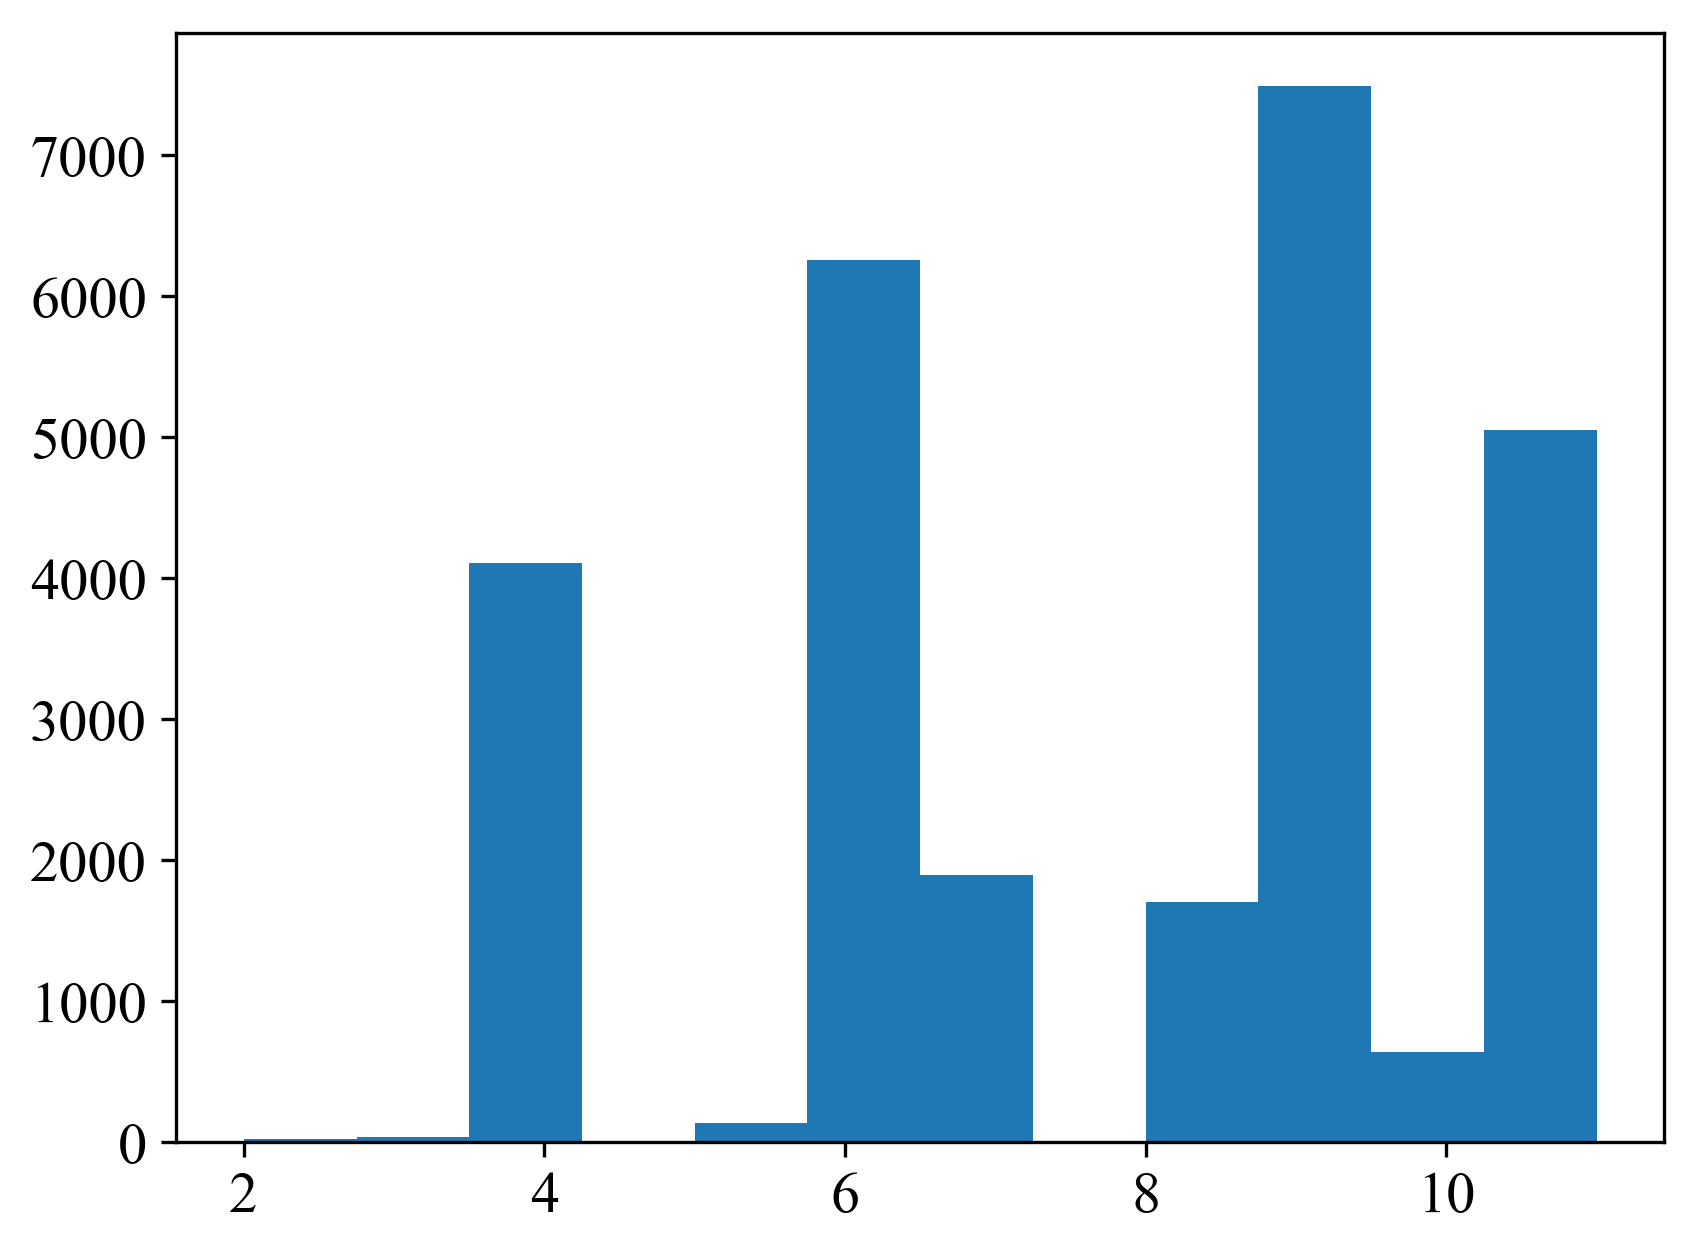

(2, 11)

In [34]:
PyPlot.plt[:hist](Dates.month.(obstime),12)
extrema(Dates.month.(obstime))

## Plot the selected data positions

In [35]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

# Extract the bathymetry for plotting

lonr = extrema(obslon[sel])
latr = extrema(obslat[sel])

lonr = -10:30
latr = 30:45 
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

INFO: Bathymetry file already downloaded


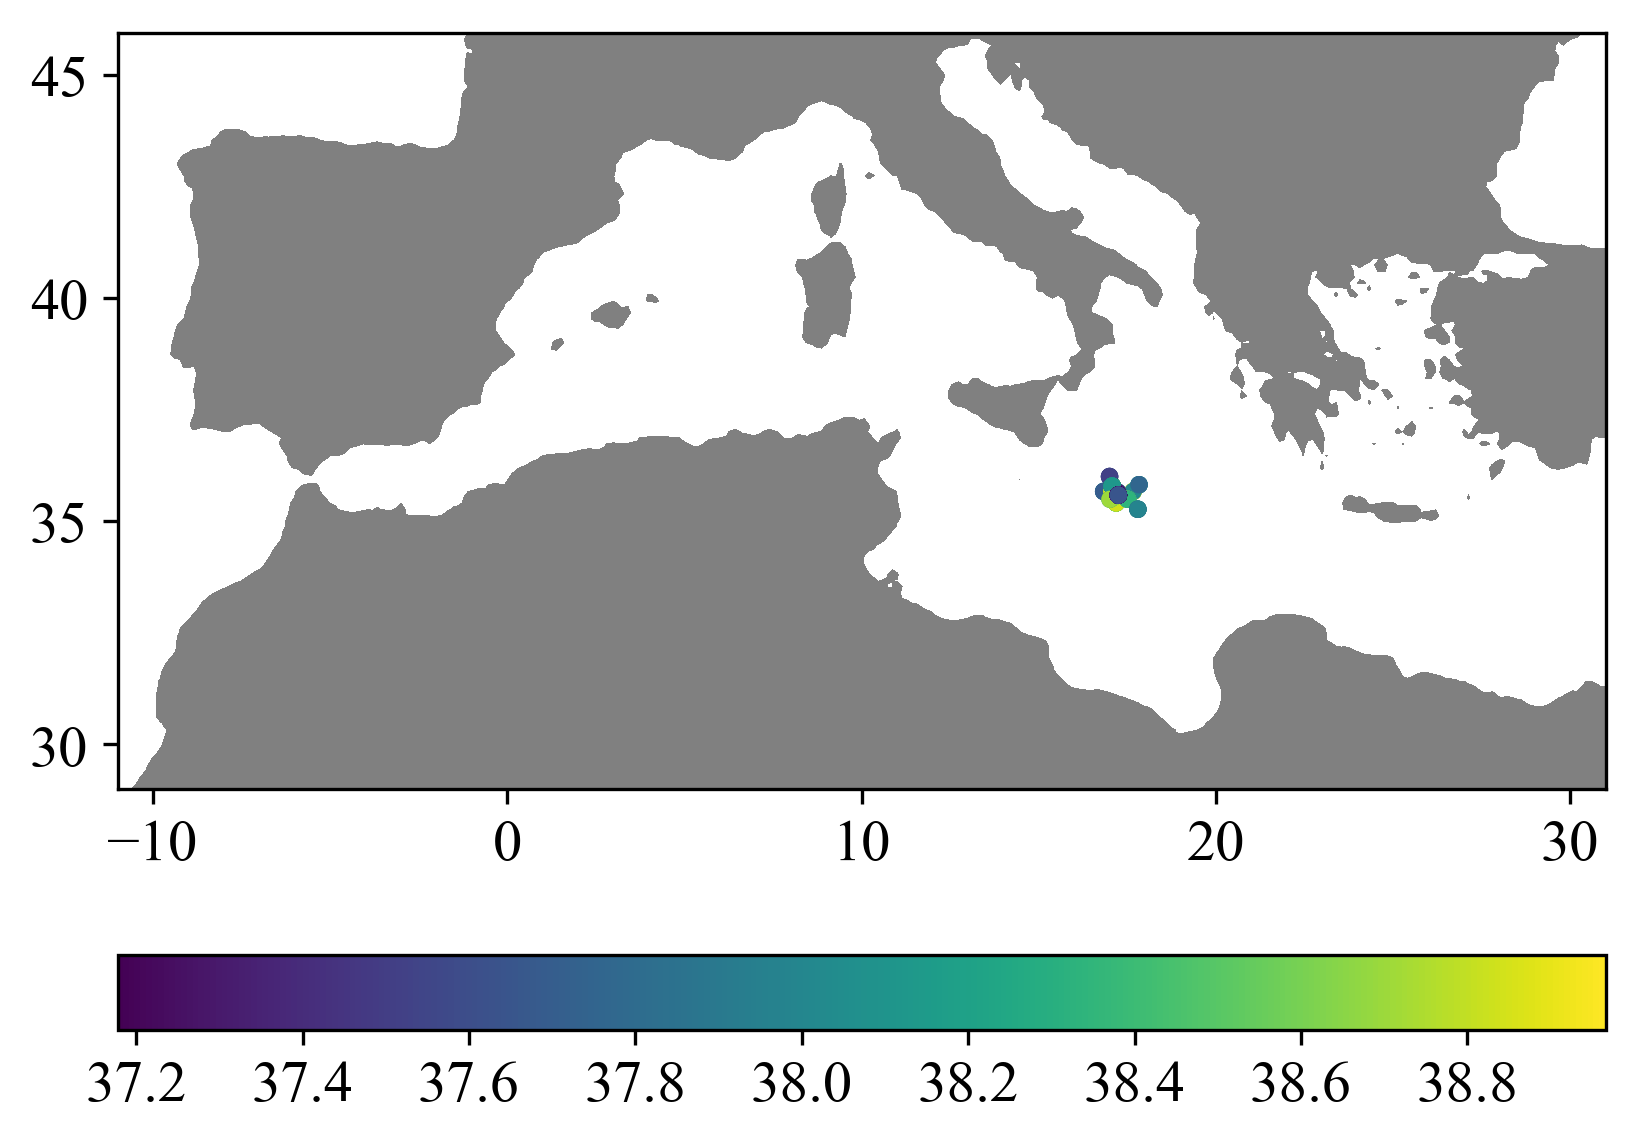

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa392423710>

In [36]:
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
scatter(obslon[sel],obslat[sel],10,obsval[sel])
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)
colorbar(orientation = "horizontal")